In [1]:
%store -r

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt


In [4]:
# Path to your ship-track text file
ship_path = "/Volumes/ct_data/equatorial_co2_data.txt"

co2_gdf = pd.read_csv(ship_path, sep=r"\s+")
co2_gdf.head()


,gps_lat_bin,gps_lon_bin,doy_co2_naf_bin,co2_naf_bin
0,4.998293,-82.073262,72.785649,428.229397
1,4.989882,-82.084128,72.787718,428.202043
2,4.981290,-82.095070,72.789815,428.107216
3,4.972995,-82.105985,72.791879,428.100543
4,4.964439,-82.116904,72.793960,428.017439


In [5]:
year = 2024
start_2024 = pd.Timestamp(f"{year}-01-01")

co2_gdf["datetime"] = start_2024 + pd.to_timedelta(
    co2_gdf["doy_co2_naf_bin"] - 1, unit="D"
)

co2_gdf[["doy_co2_naf_bin", "datetime"]].head()


,doy_co2_naf_bin,datetime
0,72.785649,2024-03-12 18:51:20.073600
1,72.787718,2024-03-12 18:54:18.835200
2,72.789815,2024-03-12 18:57:20.016000
3,72.791879,2024-03-12 19:00:18.345600
4,72.793960,2024-03-12 19:03:18.144000


In [6]:
ct_pattern = "/Volumes/ct_data/carbon_tracker_ocean/CT2025.molefrac_glb3x2_2024-*.nc"

ds_ct = xr.open_mfdataset(ct_pattern, combine="by_coords")

lat_name = "latitude"
lon_name = "longitude"
var_name = "pbl_co2"

pbl = ds_ct[var_name]   # (time, latitude, longitude)
pbl


/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_4132/494197000.py:3: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds_ct = xr.open_mfdataset(ct_pattern, combine="by_coords")


<xarray.DataArray 'pbl_co2' (time: 2928, latitude: 90, longitude: 120)> Size: 126MB
dask.array<concatenate, shape=(2928, 90, 120), dtype=float32, chunksize=(8, 90, 120), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 23kB 2024-01-01T01:30:00 ... 2024-12-31T...
  * latitude   (latitude) float64 720B -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
  * longitude  (longitude) float64 960B -178.5 -175.5 -172.5 ... 175.5 178.5
Attributes:
    PBL:           PBL pressure-averaged mole fraction
    cell_methods:  time: mean
    units:         micromol mol-1
    comment:       CT2025 estimate of total atmospheric carbon dioxide averag...

In [7]:
points_time = xr.DataArray(co2_gdf["datetime"].values,   dims="points")
points_lat  = xr.DataArray(co2_gdf["gps_lat_bin"].values, dims="points")
points_lon  = xr.DataArray(co2_gdf["gps_lon_bin"].values, dims="points")

ct_along_track = pbl.interp(
    time=points_time,
    latitude=points_lat,
    longitude=points_lon,
    method="nearest",  # or "linear" if you prefer
)

co2_gdf["CT_PBL_CO2"] = ct_along_track.values
co2_gdf[["co2_naf_bin", "CT_PBL_CO2"]].head()


,co2_naf_bin,CT_PBL_CO2
0,428.229397,426.609741
1,428.202043,426.609741
2,428.107216,426.609741
3,428.100543,426.609741
4,428.017439,426.609741


In [9]:
mbl_path = "/Volumes/ct_data/mbl_data_ocean/mbl_surface_2024.txt"

# load numeric part of the MBL file (header lines start with '#')
mbl_data = np.loadtxt(mbl_path, comments="#")

decimal_year = mbl_data[:, 0]      # shape (N_time,)
co2_lat_vals = mbl_data[:, 1::2]   # CO2 columns, every other col

# Sine-of-latitude grid used in the file
mbl_sin_lats = np.linspace(-1.0, 1.0, co2_lat_vals.shape[1])
mbl_lats = np.degrees(np.arcsin(mbl_sin_lats))  # convert sin(lat) → lat in degrees

# Convert decimal year → approximate datetime for 2024
year = 2024
start = pd.Timestamp(f"{year}-01-01")
# 2024 is leap year → 366 days
mbl_times = start + pd.to_timedelta((decimal_year - year) * 366, unit="D")

mbl_da = xr.DataArray(
    co2_lat_vals,
    coords={"time": mbl_times, "latitude": mbl_lats},
    dims=("time", "latitude"),
    name="MBL_CO2"
)

mbl_da


<xarray.DataArray 'MBL_CO2' (time: 49, latitude: 41)> Size: 16kB
array([[417.856, 417.768, 417.66 , ..., 427.594, 427.703, 427.753],
       [417.854, 417.765, 417.656, ..., 427.891, 428.025, 428.096],
       [417.863, 417.778, 417.673, ..., 428.157, 428.32 , 428.416],
       ...,
       [421.678, 421.584, 421.465, ..., 431.203, 431.196, 431.158],
       [421.706, 421.611, 421.49 , ..., 431.566, 431.553, 431.512],
       [421.67 , 421.579, 421.464, ..., 431.574, 431.693, 431.813]],
      shape=(49, 41))
Coordinates:
  * time      (time) datetime64[ns] 392B 2024-01-01 ... 2025-01-01
  * latitude  (latitude) float64 328B -90.0 -71.81 -64.16 ... 64.16 71.81 90.0

In [10]:
points_time_mbl = xr.DataArray(co2_gdf["datetime"].values,   dims="points")
points_lat_mbl  = xr.DataArray(co2_gdf["gps_lat_bin"].values, dims="points")

mbl_along_track = mbl_da.interp(
    time=points_time_mbl,
    latitude=points_lat_mbl,
    method="linear"
)

co2_gdf["MBL_CO2"] = mbl_along_track.values
co2_gdf[["co2_naf_bin", "CT_PBL_CO2", "MBL_CO2"]].head()


,co2_naf_bin,CT_PBL_CO2,MBL_CO2
0,428.229397,426.609741,423.474155
1,428.202043,426.609741,423.472100
2,428.107216,426.609741,423.470001
3,428.100543,426.609741,423.467975
4,428.017439,426.609741,423.465883


In [12]:
growth_2024 = 3.33   # ppm
growth_unc  = 0.11   # ppm (optional, if you want uncertainty)

co2_gdf["ship_co2_2024_equiv"] = co2_gdf["co2_naf_bin"] - growth_2024


In [13]:
co2_gdf["ship_co2_2024_equiv_unc"] = growth_unc


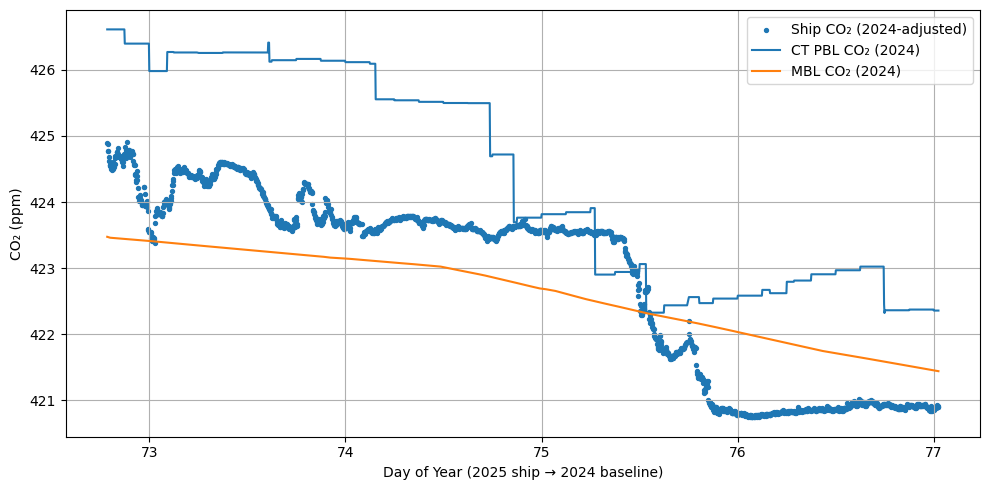

In [14]:
plt.figure(figsize=(10,5))

plt.scatter(
    co2_gdf["doy_co2_naf_bin"],
    co2_gdf["ship_co2_2024_equiv"],
    s=8, label="Ship CO₂ (2024-adjusted)"
)

plt.plot(
    co2_gdf["doy_co2_naf_bin"],
    co2_gdf["CT_PBL_CO2"],
    label="CT PBL CO₂ (2024)"
)

plt.plot(
    co2_gdf["doy_co2_naf_bin"],
    co2_gdf["MBL_CO2"],
    label="MBL CO₂ (2024)"
)

plt.xlabel("Day of Year (2025 ship → 2024 baseline)")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
co2_gdf["doy_corrected"] = co2_gdf["doy_co2_naf_bin"] - 1


In [16]:
year = 2024
start_2024 = pd.Timestamp(f"{year}-01-01")

co2_gdf["datetime"] = start_2024 + pd.to_timedelta(
    co2_gdf["doy_corrected"], unit="D"
)


In [17]:
growth_2024 = 3.33    # ppm
co2_gdf["ship_co2_2024_equiv"] = co2_gdf["co2_naf_bin"] - growth_2024


In [19]:

# --- copy to be safe ---
co2_gdf = co2_gdf.copy()

# 1. Leap-year DOY correction: 2025 ship DOY -> 2024 DOY
# (You decided to subtract 1 day to match 2024's leap-year DOY indexing)
co2_gdf["doy_2024"] = co2_gdf["doy_co2_naf_bin"] - 1.0

# Optional: real datetime in 2024 for plotting on a date axis
year = 2024
start_2024 = pd.Timestamp(f"{year}-01-01")
co2_gdf["time_2024"] = start_2024 + pd.to_timedelta(co2_gdf["doy_2024"], unit="D")

# 2. Mauna Loa annual growth correction (2025 -> 2024 baseline)
growth_2024 = 3.33  # ppm
co2_gdf["ship_co2_2024_equiv"] = co2_gdf["co2_naf_bin"] - growth_2024


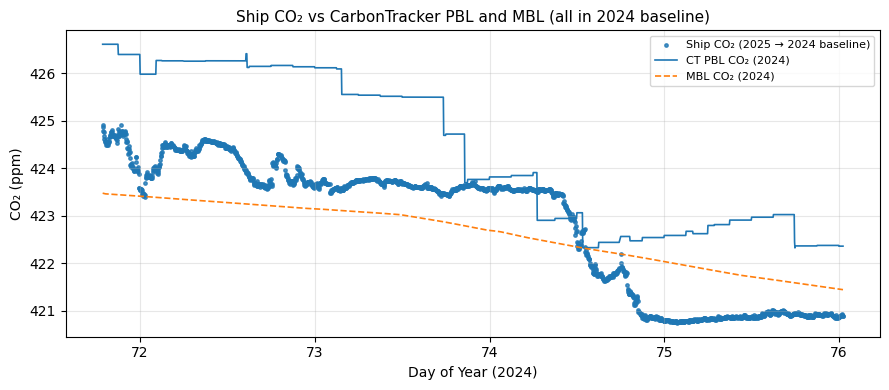

In [20]:
plt.figure(figsize=(9, 4))

# Ship CO₂ (2025 adjusted back to 2024 baseline)
plt.scatter(
    co2_gdf["doy_2024"],
    co2_gdf["ship_co2_2024_equiv"],
    s=6,
    alpha=0.8,
    label="Ship CO₂ (2025 → 2024 baseline)",
)

# CarbonTracker PBL CO₂ along track (already 2024)
plt.plot(
    co2_gdf["doy_2024"],
    co2_gdf["CT_PBL_CO2"],
    linewidth=1.2,
    label="CT PBL CO₂ (2024)",
)

# MBL reference along track (already 2024)
plt.plot(
    co2_gdf["doy_2024"],
    co2_gdf["MBL_CO2"],
    linewidth=1.2,
    linestyle="--",
    label="MBL CO₂ (2024)",
)

plt.xlabel("Day of Year (2024)", fontsize=10)
plt.ylabel("CO₂ (ppm)", fontsize=10)
plt.title("Ship CO₂ vs CarbonTracker PBL and MBL (all in 2024 baseline)", fontsize=11)
plt.legend(fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


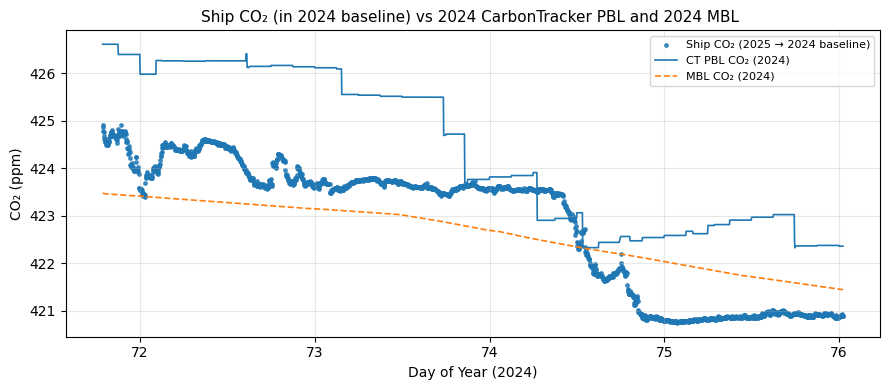

In [48]:
plt.figure(figsize=(9, 4))

# Ship CO₂ (2025 adjusted back to 2024 baseline)
plt.scatter(
    co2_gdf["doy_2024"],
    co2_gdf["ship_co2_2024_equiv"],
    s=6,
    alpha=0.8,
    label="Ship CO₂ (2025 → 2024 baseline)",
)

# CarbonTracker PBL CO₂ along track (already 2024)
plt.plot(
    co2_gdf["doy_2024"],
    co2_gdf["CT_PBL_CO2"],
    linewidth=1.2,
    label="CT PBL CO₂ (2024)",
)

# MBL reference along track (already 2024)
plt.plot(
    co2_gdf["doy_2024"],
    co2_gdf["MBL_CO2"],
    linewidth=1.2,
    linestyle="--",
    label="MBL CO₂ (2024)",
)

plt.xlabel("Day of Year (2024)", fontsize=10)
plt.ylabel("CO₂ (ppm)", fontsize=10)
plt.title("Ship CO₂ (in 2024 baseline) vs 2024 CarbonTracker PBL and 2024 MBL ", fontsize=11)
plt.legend(fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


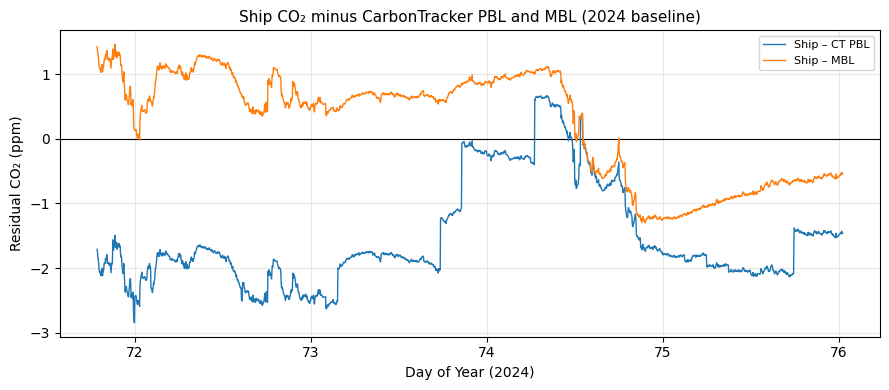

In [22]:
# Residuals
co2_gdf["res_ship_minus_CT"]  = co2_gdf["ship_co2_2024_equiv"] - co2_gdf["CT_PBL_CO2"]
co2_gdf["res_ship_minus_MBL"] = co2_gdf["ship_co2_2024_equiv"] - co2_gdf["MBL_CO2"]

plt.figure(figsize=(9, 4))

plt.axhline(0, color="k", linewidth=0.8)

plt.plot(
    co2_gdf["doy_2024"],
    co2_gdf["res_ship_minus_CT"],
    label="Ship – CT PBL",
    linewidth=1.0,
)

plt.plot(
    co2_gdf["doy_2024"],
    co2_gdf["res_ship_minus_MBL"],
    label="Ship – MBL",
    linewidth=1.0,
)

plt.xlabel("Day of Year (2024)", fontsize=10)
plt.ylabel("Residual CO₂ (ppm)", fontsize=10)
plt.title("Ship CO₂ minus CarbonTracker PBL and MBL (2024 baseline)", fontsize=11)
plt.legend(fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


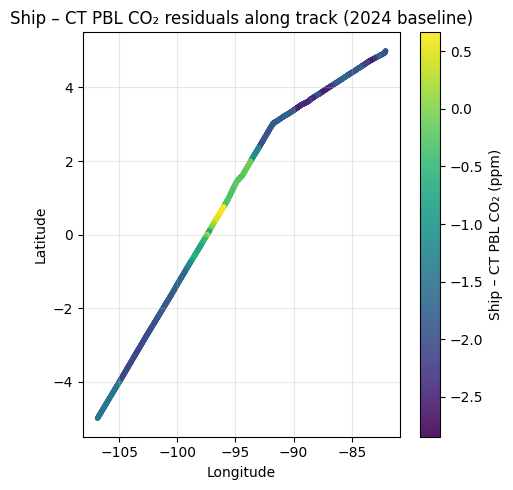

In [23]:
plt.figure(figsize=(5, 5))

sc = plt.scatter(
    co2_gdf["gps_lon_bin"],
    co2_gdf["gps_lat_bin"],
    c=co2_gdf["res_ship_minus_CT"],
    s=8,
    alpha=0.9,
)

plt.colorbar(sc, label="Ship – CT PBL CO₂ (ppm)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ship – CT PBL CO₂ residuals along track (2024 baseline)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


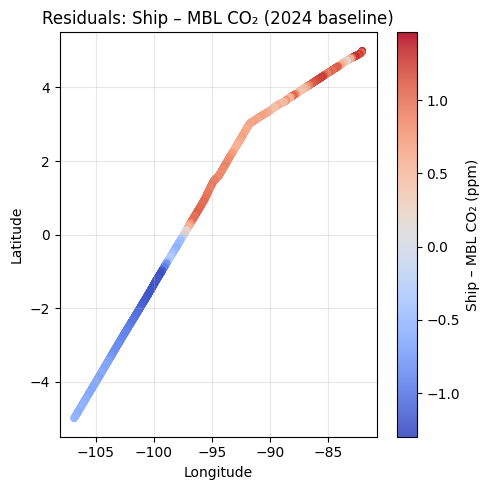

In [24]:
plt.figure(figsize=(5,5))

sc = plt.scatter(
    co2_gdf["gps_lon_bin"],
    co2_gdf["gps_lat_bin"],
    c=co2_gdf["res_ship_minus_MBL"],
    cmap="coolwarm",
    s=20,
    alpha=0.9
)

plt.colorbar(sc, label="Ship – MBL CO₂ (ppm)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Residuals: Ship – MBL CO₂ (2024 baseline)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


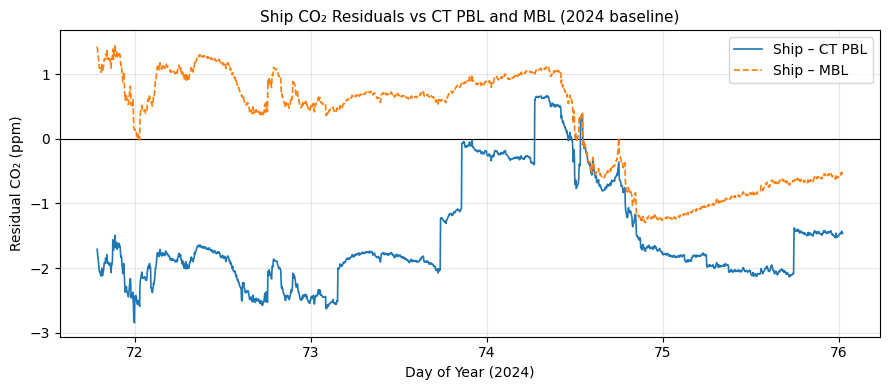

In [25]:
plt.figure(figsize=(9, 4))

plt.axhline(0, color="k", linewidth=0.8)

plt.plot(
    co2_gdf["doy_2024"],
    co2_gdf["res_ship_minus_CT"],
    label="Ship – CT PBL",
    linewidth=1.2,
)

plt.plot(
    co2_gdf["doy_2024"],
    co2_gdf["res_ship_minus_MBL"],
    label="Ship – MBL",
    linewidth=1.2,
    linestyle="--"
)

plt.xlabel("Day of Year (2024)", fontsize=10)
plt.ylabel("Residual CO₂ (ppm)", fontsize=10)
plt.title("Ship CO₂ Residuals vs CT PBL and MBL (2024 baseline)", fontsize=11)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


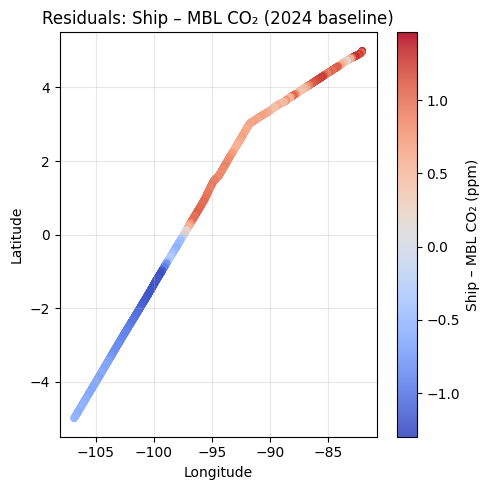

In [26]:
plt.figure(figsize=(5,5))

sc = plt.scatter(
    co2_gdf["gps_lon_bin"],
    co2_gdf["gps_lat_bin"],
    c=co2_gdf["res_ship_minus_MBL"],
    cmap="coolwarm",
    s=20,
    alpha=0.9
)

plt.colorbar(sc, label="Ship – MBL CO₂ (ppm)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Residuals: Ship – MBL CO₂ (2024 baseline)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


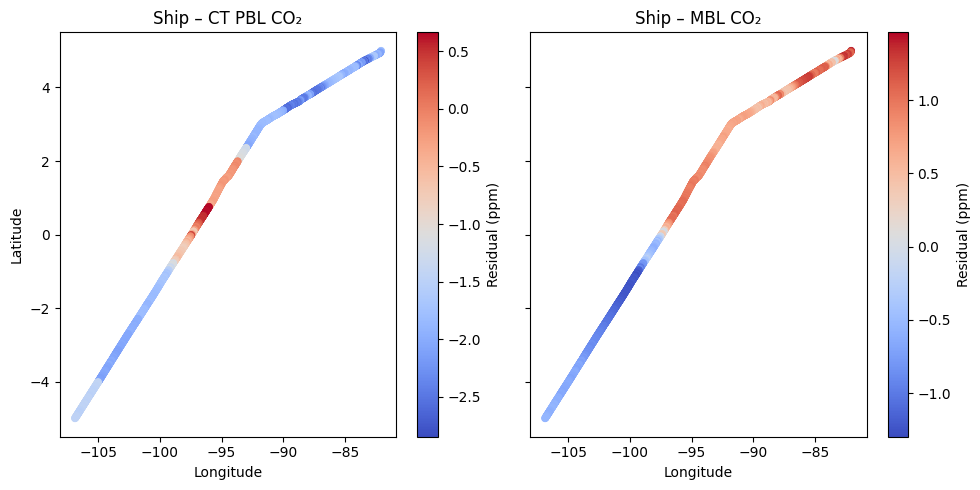

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

# Ship – CT
sc1 = axes[0].scatter(
    co2_gdf["gps_lon_bin"],
    co2_gdf["gps_lat_bin"],
    c=co2_gdf["res_ship_minus_CT"],
    cmap="coolwarm",
    s=20
)
axes[0].set_title("Ship – CT PBL CO₂")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
fig.colorbar(sc1, ax=axes[0], label="Residual (ppm)")

# Ship – MBL
sc2 = axes[1].scatter(
    co2_gdf["gps_lon_bin"],
    co2_gdf["gps_lat_bin"],
    c=co2_gdf["res_ship_minus_MBL"],
    cmap="coolwarm",
    s=20
)
axes[1].set_title("Ship – MBL CO₂")
axes[1].set_xlabel("Longitude")
fig.colorbar(sc2, ax=axes[1], label="Residual (ppm)")

plt.tight_layout()
plt.show()


/Users/gml/.pyenv/versions/3.11.2/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/gml/.pyenv/versions/3.11.2/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/gml/.pyenv/versions/3.11.2/lib/python3.11/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


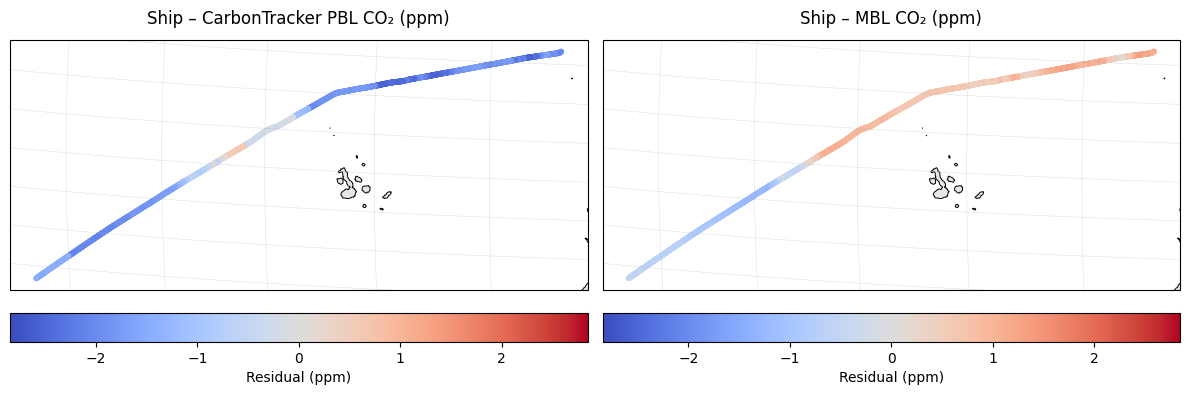

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Pull from your existing gdf
lons = co2_gdf["gps_lon_bin"].values
lats = co2_gdf["gps_lat_bin"].values
res_ct  = co2_gdf["res_ship_minus_CT"].values
res_mbl = co2_gdf["res_ship_minus_MBL"].values

# Symmetric color scale across both plots
all_res = np.concatenate([res_ct, res_mbl])
vmax = np.nanmax(np.abs(all_res))
vmin = -vmax

# Projection: looks like a 3-D globe, centered on your region
proj_globe = ccrs.Orthographic(central_longitude=-60, central_latitude=5)
data_crs  = ccrs.PlateCarree()   # for lon/lat input

fig = plt.figure(figsize=(12, 5))

# ---------- 1) Ship – CT PBL CO₂ ----------
ax1 = plt.subplot(1, 2, 1, projection=proj_globe)
ax1.set_title("Ship – CarbonTracker PBL CO₂ (ppm)", pad=12)

ax1.add_feature(cfeature.LAND, facecolor="0.9")
ax1.add_feature(cfeature.OCEAN, facecolor="white")
ax1.coastlines(linewidth=0.7)
ax1.gridlines(draw_labels=False, linewidth=0.3, alpha=0.5)

sc1 = ax1.scatter(
    lons, lats,
    c=res_ct,
    s=10,
    cmap="coolwarm",
    vmin=vmin, vmax=vmax,
    transform=data_crs,
)

cb1 = fig.colorbar(sc1, ax=ax1, orientation="horizontal", pad=0.05)
cb1.set_label("Residual (ppm)")

# ---------- 2) Ship – MBL CO₂ ----------
ax2 = plt.subplot(1, 2, 2, projection=proj_globe)
ax2.set_title("Ship – MBL CO₂ (ppm)", pad=12)

ax2.add_feature(cfeature.LAND, facecolor="0.9")
ax2.add_feature(cfeature.OCEAN, facecolor="white")
ax2.coastlines(linewidth=0.7)
ax2.gridlines(draw_labels=False, linewidth=0.3, alpha=0.5)

sc2 = ax2.scatter(
    lons, lats,
    c=res_mbl,
    s=10,
    cmap="coolwarm",
    vmin=vmin, vmax=vmax,
    transform=data_crs,
)

cb2 = fig.colorbar(sc2, ax=ax2, orientation="horizontal", pad=0.05)
cb2.set_label("Residual (ppm)")

plt.tight_layout()
plt.show()


In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from geodatasets import get_path

# Get a Natural Earth land layer (110m land polygons)
world_path = get_path("naturalearth.land")
world = gpd.read_file(world_path)

from geodatasets import dataset_names
print(dataset_names())


ImportError: cannot import name 'dataset_names' from 'geodatasets' (/Users/gml/.pyenv/versions/3.11.2/lib/python3.11/site-packages/geodatasets/__init__.py)

In [37]:
import geopandas as gpd
from shapely.geometry import Point

co2_gdf = co2_gdf.copy()

# Make geometry from lon/lat
co2_gdf["geometry"] = co2_gdf.apply(
    lambda row: Point(row["gps_lon_bin"], row["gps_lat_bin"]),
    axis=1
)

# Set CRS (lat/lon WGS84)
co2_gdf = gpd.GeoDataFrame(co2_gdf, geometry="geometry", crs="EPSG:4326")


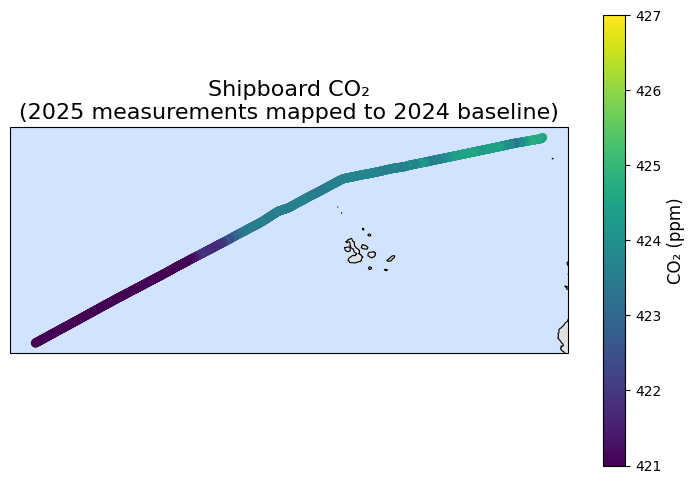

In [54]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Projection centered on your region
proj = ccrs.Orthographic(central_longitude=-90, central_latitude=2)

fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection=proj)

# Add land, ocean, coastlines
ax.add_feature(cfeature.LAND, facecolor="#e0e0e0")
ax.add_feature(cfeature.OCEAN, facecolor="#d1e3ff")
ax.coastlines(linewidth=0.8)

# Plot ship points
sc = ax.scatter(
    co2_gdf["gps_lon_bin"],
    co2_gdf["gps_lat_bin"],
    c=co2_gdf["ship_co2_2024_equiv"],
    cmap="viridis",
    vmin=421,         
    vmax=427, 
    s=30,
    transform=ccrs.PlateCarree(),
    zorder=3
)

# Title
plt.title("Shipboard CO₂\n(2025 measurements mapped to 2024 baseline)", fontsize=16)

# Colorbar
cb = plt.colorbar(sc, shrink=0.65)
cb.set_label("CO₂ (ppm)", fontsize=12)

plt.show()


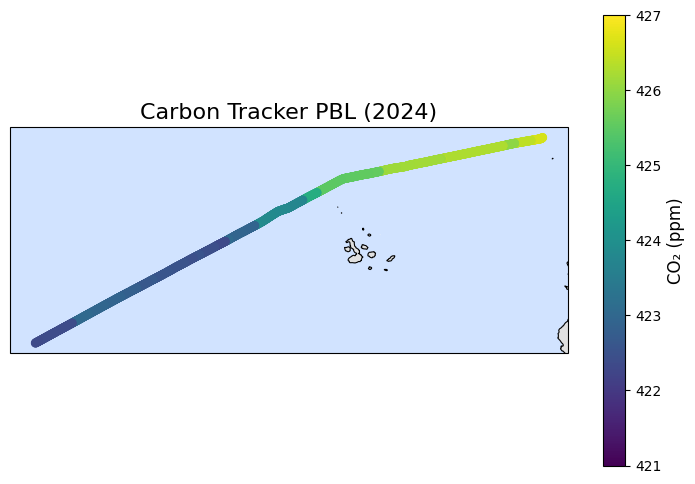

In [55]:
# Projection centered on your region
proj = ccrs.Orthographic(central_longitude=-90, central_latitude=2)

fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection=proj)

# Add land, ocean, coastlines
ax.add_feature(cfeature.LAND, facecolor="#e0e0e0")
ax.add_feature(cfeature.OCEAN, facecolor="#d1e3ff")
ax.coastlines(linewidth=0.8)

# Plot ship points
sc = ax.scatter(
    co2_gdf["gps_lon_bin"],
    co2_gdf["gps_lat_bin"],
    c=co2_gdf["CT_PBL_CO2"],
    cmap="viridis",
    vmin=421,         
    vmax=427, 
    s=30,
    transform=ccrs.PlateCarree(),
    zorder=3
)

# Title
plt.title("Carbon Tracker PBL (2024)", fontsize=16)

# Colorbar
cb = plt.colorbar(sc, shrink=0.65)
cb.set_label("CO₂ (ppm)", fontsize=12)

plt.show()


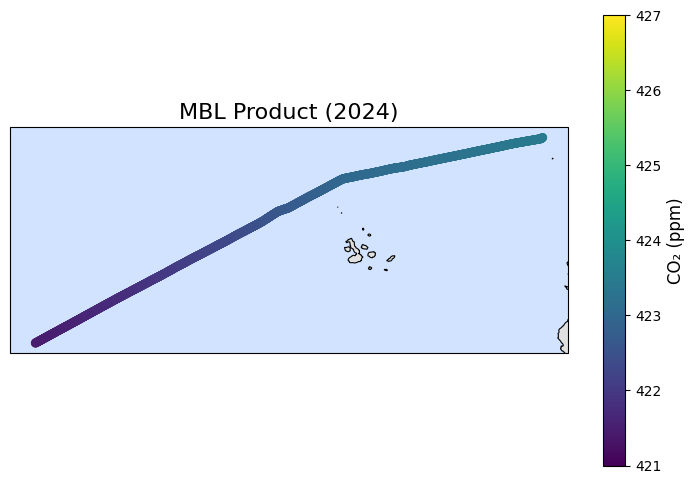

In [56]:
# Projection centered on your region
proj = ccrs.Orthographic(central_longitude=-90, central_latitude=2)

fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection=proj)

# Add land, ocean, coastlines
ax.add_feature(cfeature.LAND, facecolor="#e0e0e0")
ax.add_feature(cfeature.OCEAN, facecolor="#d1e3ff")
ax.coastlines(linewidth=0.8)

# Plot ship points
sc = ax.scatter(
    co2_gdf["gps_lon_bin"],
    co2_gdf["gps_lat_bin"],
    c=co2_gdf["MBL_CO2"],
    cmap="viridis",
    s=30,
    vmin=421,         
    vmax=427, 
    transform=ccrs.PlateCarree(),
    zorder=3
)

# Title
plt.title("MBL Product (2024)", fontsize=16)

# Colorbar
cb = plt.colorbar(sc, shrink=0.65)
cb.set_label("CO₂ (ppm)", fontsize=12)

plt.show()

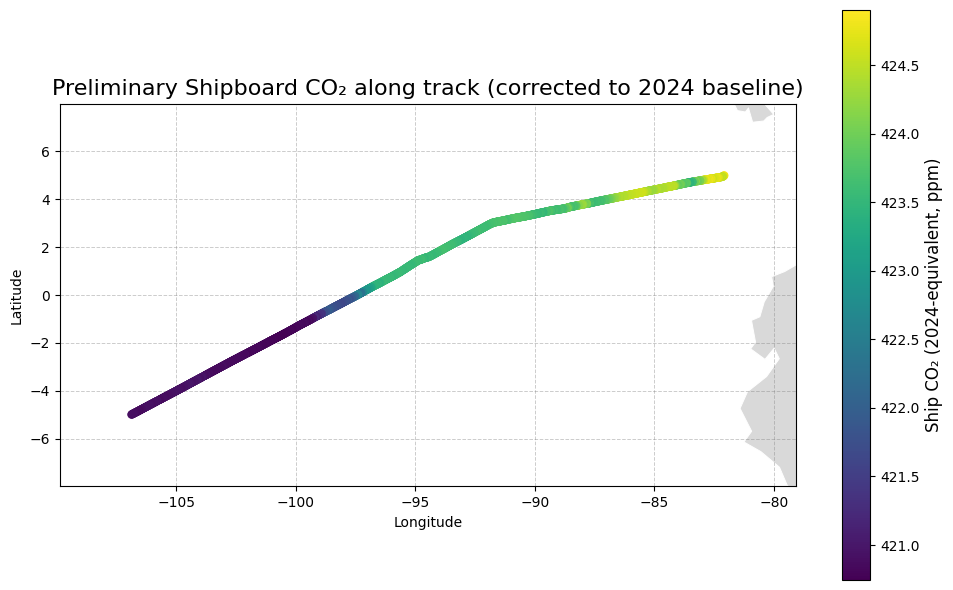

In [46]:
import matplotlib.pyplot as plt
import geopandas as gpd
from geodatasets import get_path

# Load land polygons
world = gpd.read_file(get_path("naturalearth.land"))

fig, ax = plt.subplots(figsize=(10, 6))

# Land (light gray)
world.plot(ax=ax, color="#d9d9d9", edgecolor="white", linewidth=0.7, zorder=1)

# Ship CO₂ (corrected)
sc = ax.scatter(
    co2_gdf["gps_lon_bin"],
    co2_gdf["gps_lat_bin"],
    c=co2_gdf["ship_co2_2024_equiv"],
    cmap="viridis",
    s=25,
    zorder=2
)

# Colorbar
cb = plt.colorbar(sc, ax=ax)
cb.set_label("Ship CO₂ (2024-equivalent, ppm)", fontsize=12)

# Title, labels
ax.set_title("Preliminary Shipboard CO₂ along track (corrected to 2024 baseline)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Gridlines
ax.grid(color="gray", linestyle="--", linewidth=0.7, alpha=0.4)

# Zoom to track
lon_pad = 3
lat_pad = 3
ax.set_xlim(
    co2_gdf["gps_lon_bin"].min() - lon_pad,
    co2_gdf["gps_lon_bin"].max() + lon_pad
)
ax.set_ylim(
    co2_gdf["gps_lat_bin"].min() - lat_pad,
    co2_gdf["gps_lat_bin"].max() + lat_pad
)

plt.tight_layout()
plt.show()


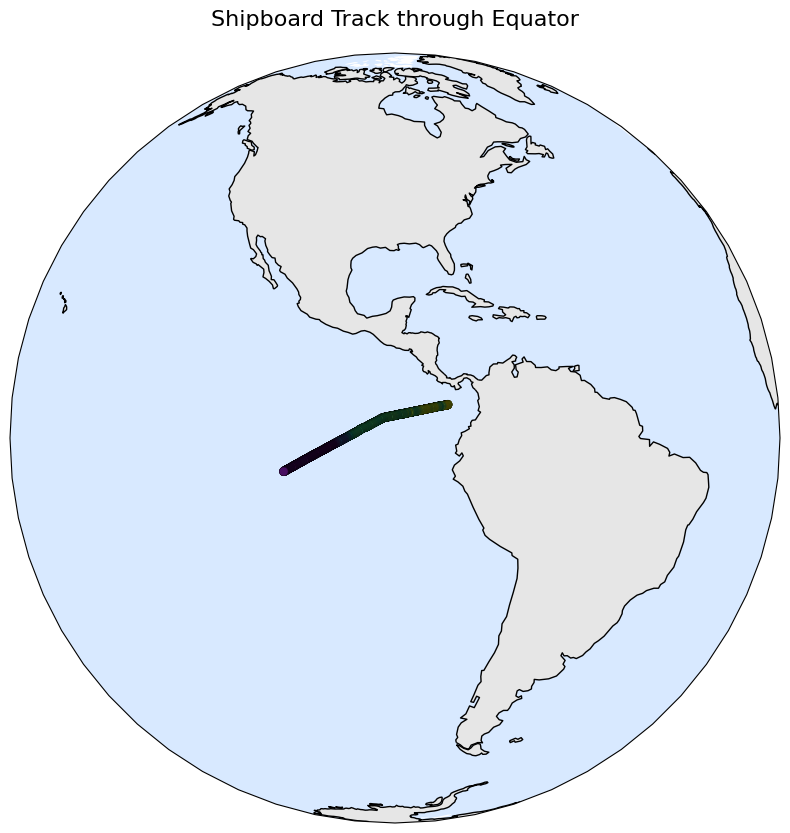

In [45]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Center the globe roughly on your region (equatorial Pacific)
lon0 = -90    # center longitude
lat0 =  0     # center latitude

proj = ccrs.Orthographic(central_longitude=lon0, central_latitude=lat0)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=proj)

# ---- LAND / OCEAN BASEMAP ----
ax.add_feature(cfeature.LAND, facecolor="#e6e6e6")
ax.add_feature(cfeature.OCEAN, facecolor="#d8e9ff")
ax.coastlines(linewidth=1.0, color="black")

# ---- PLOT SHIP CO₂ ----
sc = ax.scatter(
    co2_gdf["gps_lon_bin"],
    co2_gdf["gps_lat_bin"],
    c=co2_gdf["ship_co2_2024_equiv"],
    cmap="viridis",
    s=40,
    edgecolor="black",
    linewidth=0.2,
    transform=ccrs.PlateCarree(),
    zorder=3
)

# ---- COLORBAR ----
#cb = plt.colorbar(sc, shrink=0.6, pad=0.05)
#cb.set_label("Ship CO₂ (2024-equivalent, ppm)", fontsize=12)

# ---- TITLE ----
plt.title(
    "Shipboard Track through Equator",
    fontsize=16,
    pad=20
)

# ---- ZOOM OUT by setting a WIDE extent ----
ax.set_global()     # show the whole visible globe
# Want even more zoom-out? uncomment:
# ax.set_extent([-180, 20, -60, 60], crs=ccrs.PlateCarree())

plt.show()
